# LSTM Modelling 

In [2]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

2023-05-30 11:53:04.149023: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 11:53:04.265806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 11:53:04.266646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 11:53:05.303911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [3]:
dataset = pd.read_csv("../DateDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [31]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [ ]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [41]:
dataset.to_csv("../DateDatasets/dataset.csv")

## Correlation Features

In [42]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345),
 ('WorkingDay', 35.49851955888466)]


## LSTM

In [17]:
epochs = 3
batch_size = 1
verbose = 2

MSE = [3.787418484687805, 3.6717960596084596, 3.6734584093093874, 3.6544564247131346, 3.627869176864624]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [45]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 08:58:37.337012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 08:58:37.338070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 08:58:37.338731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 157s - loss: 4.0357 - accuracy: 0.3337 - 157s/epoch - 856us/step


2023-05-19 09:01:14.444546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 09:01:14.446141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 09:01:14.447017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 153s - loss: 3.8385 - accuracy: 0.3338 - 153s/epoch - 838us/step
182982/182982 - 153s - loss: 3.8199 - accuracy: 0.3336 - 153s/epoch - 837us/step
182971/182971 - 154s - loss: 3.7754 - accuracy: 0.3335 - 154s/epoch - 839us/step
182971/182971 - 153s - loss: 3.7376 - accuracy: 0.3337 - 153s/epoch - 838us/step
182972/182972 - 153s - loss: 3.7158 - accuracy: 0.3326 - 153s/epoch - 837us/step
183007/183007 - 152s - loss: 3.7006 - accuracy: 0.3326 - 152s/epoch - 830us/step
183180/183180 - 154s - loss: 3.6860 - accuracy: 0.3334 - 154s/epoch - 838us/step
183176/183176 - 154s - loss: 3.6613 - accuracy: 0.3330 - 154s/epoch - 839us/step
183180/183180 - 154s - loss: 3.6878 - accuracy: 0.3334 - 154s/epoch - 840us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.7353336811065674 - Accuracy: 33.40420126914978%
-------------------------------------------

Text(0.5, 0, 'Methods')

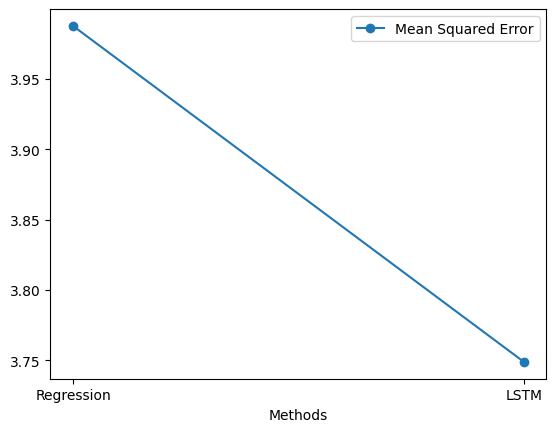

In [53]:
plt.plot(["Regression", "LSTM"], [3.9876557741635343, 3.748756194114685], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [11]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-30 13:11:11.037689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 13:11:11.039865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 13:11:11.041559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 189s - loss: 4.0013 - accuracy: 0.3338 - 189s/epoch - 1ms/step


2023-05-30 13:14:20.079534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 13:14:20.081702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 13:14:20.084011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 175s - loss: 3.7886 - accuracy: 0.3339 - 175s/epoch - 957us/step
182982/182982 - 168s - loss: 3.7878 - accuracy: 0.3338 - 168s/epoch - 916us/step
182971/182971 - 169s - loss: 3.7713 - accuracy: 0.3339 - 169s/epoch - 922us/step
182971/182971 - 157s - loss: 3.7597 - accuracy: 0.3343 - 157s/epoch - 859us/step
182972/182972 - 169s - loss: 3.7764 - accuracy: 0.3334 - 169s/epoch - 924us/step
183007/183007 - 173s - loss: 3.7712 - accuracy: 0.3334 - 173s/epoch - 944us/step
183180/183180 - 170s - loss: 3.7551 - accuracy: 0.3341 - 170s/epoch - 930us/step
183176/183176 - 156s - loss: 3.7246 - accuracy: 0.3338 - 156s/epoch - 851us/step
183180/183180 - 154s - loss: 3.7498 - accuracy: 0.3341 - 154s/epoch - 842us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.755969285964966 - Accuracy: 33.39431285858154%
--------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [12]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-30 13:39:16.804886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 13:39:16.806081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 13:39:16.806784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 154s - loss: 3.9963 - accuracy: 0.3331 - 154s/epoch - 841us/step


2023-05-30 13:41:51.081291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 13:41:51.082492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 13:41:51.083219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 154s - loss: 3.7164 - accuracy: 0.3335 - 154s/epoch - 841us/step
182982/182982 - 157s - loss: 3.6923 - accuracy: 0.3327 - 157s/epoch - 856us/step
182971/182971 - 159s - loss: 3.6730 - accuracy: 0.3323 - 159s/epoch - 869us/step
182971/182971 - 159s - loss: 3.6694 - accuracy: 0.3328 - 159s/epoch - 866us/step
182972/182972 - 156s - loss: 3.6660 - accuracy: 0.3313 - 156s/epoch - 855us/step
183007/183007 - 157s - loss: 3.6598 - accuracy: 0.3318 - 157s/epoch - 858us/step
183180/183180 - 155s - loss: 3.6434 - accuracy: 0.3321 - 155s/epoch - 844us/step
183176/183176 - 156s - loss: 3.6178 - accuracy: 0.3320 - 156s/epoch - 852us/step
183180/183180 - 157s - loss: 3.6423 - accuracy: 0.3325 - 157s/epoch - 857us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.7293691635131836 - Accuracy: 33.40420126914978%
-------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [13]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-30 14:05:24.978932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 14:05:24.979941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 14:05:24.980567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 158s - loss: 3.9847 - accuracy: 0.3336 - 158s/epoch - 863us/step


2023-05-30 14:08:03.276383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 14:08:03.277675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 14:08:03.278375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 162s - loss: 3.7262 - accuracy: 0.3334 - 162s/epoch - 883us/step
182982/182982 - 156s - loss: 3.7030 - accuracy: 0.3330 - 156s/epoch - 850us/step
182971/182971 - 153s - loss: 3.6657 - accuracy: 0.3324 - 153s/epoch - 837us/step
182971/182971 - 153s - loss: 3.6452 - accuracy: 0.3324 - 153s/epoch - 835us/step
182972/182972 - 154s - loss: 3.6444 - accuracy: 0.3310 - 154s/epoch - 842us/step
183007/183007 - 153s - loss: 3.6352 - accuracy: 0.3305 - 153s/epoch - 836us/step
183180/183180 - 161s - loss: 3.6190 - accuracy: 0.3312 - 161s/epoch - 879us/step
183176/183176 - 165s - loss: 3.5980 - accuracy: 0.3306 - 165s/epoch - 898us/step
183180/183180 - 168s - loss: 3.6180 - accuracy: 0.3306 - 168s/epoch - 917us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.6467132568359375 - Accuracy: 33.37948024272919%
-------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [14]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-30 14:31:52.145929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 14:31:52.147398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 14:31:52.148082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 160s - loss: 4.0098 - accuracy: 0.3332 - 160s/epoch - 872us/step


2023-05-30 14:34:32.049661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 14:34:32.050825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 14:34:32.051518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 157s - loss: 3.7357 - accuracy: 0.3332 - 157s/epoch - 861us/step
182982/182982 - 151s - loss: 3.7027 - accuracy: 0.3324 - 151s/epoch - 823us/step
182971/182971 - 154s - loss: 3.6710 - accuracy: 0.3325 - 154s/epoch - 844us/step
182971/182971 - 154s - loss: 3.6423 - accuracy: 0.3327 - 154s/epoch - 844us/step
182972/182972 - 154s - loss: 3.6396 - accuracy: 0.3318 - 154s/epoch - 841us/step
183007/183007 - 154s - loss: 3.6267 - accuracy: 0.3318 - 154s/epoch - 842us/step
183180/183180 - 155s - loss: 3.6049 - accuracy: 0.3328 - 155s/epoch - 845us/step
183176/183176 - 153s - loss: 3.5778 - accuracy: 0.3326 - 153s/epoch - 836us/step
183180/183180 - 156s - loss: 3.5994 - accuracy: 0.3331 - 156s/epoch - 851us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.732678174972534 - Accuracy: 33.39925706386566%
--------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [16]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["Day"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-30 15:00:42.736966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:00:42.738008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:00:42.738704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183178/183178 - 169s - loss: 3.9427 - accuracy: 0.3332 - 169s/epoch - 920us/step


2023-05-30 15:03:31.629817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 15:03:31.631313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 15:03:31.632158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183010/183010 - 148s - loss: 3.7479 - accuracy: 0.3338 - 148s/epoch - 811us/step
182982/182982 - 143s - loss: 3.7212 - accuracy: 0.3335 - 143s/epoch - 781us/step
182971/182971 - 144s - loss: 3.6771 - accuracy: 0.3336 - 144s/epoch - 787us/step
182971/182971 - 145s - loss: 3.6491 - accuracy: 0.3340 - 145s/epoch - 790us/step
182972/182972 - 143s - loss: 3.6347 - accuracy: 0.3330 - 143s/epoch - 782us/step
183007/183007 - 141s - loss: 3.6160 - accuracy: 0.3328 - 141s/epoch - 771us/step
183180/183180 - 156s - loss: 3.5950 - accuracy: 0.3334 - 156s/epoch - 851us/step
183176/183176 - 161s - loss: 3.5701 - accuracy: 0.3332 - 161s/epoch - 878us/step
183180/183180 - 148s - loss: 3.5897 - accuracy: 0.3337 - 148s/epoch - 806us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 3.6647868156433105 - Accuracy: 33.33498239517212%
-------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

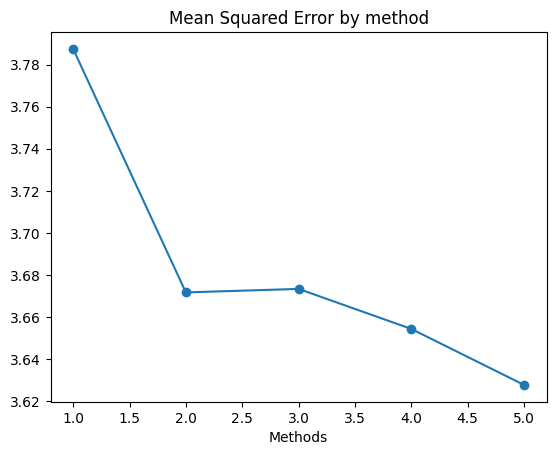

In [18]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")